In [1]:
import sys, time, math, os
import numpy as np
import pandas as pd
import time, math, random, math
import datetime
import copy
from tqdm import tqdm
from collections import Counter, OrderedDict

import matplotlib.pyplot as plt
%matplotlib inline

%reload_ext autoreload
%autoreload 2

# Functions

In [2]:
def plot_component(x, y, name):
    plt.figure(figsize=(6, 4))
    plt.plot(x, y)
    plt.title('Component: ' + str(name))
    plt.ylim([0, 30])
    plt.xlim([x[0], x[-1]])
    plt.show()

In [3]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

# Creating the components

## Info

Distributed energy grid contains:

- WT = small wind turbine:
        output = 5, amplitude = 2, period length (hours) = 1, start-up time (hours) = 10min, stop time = 10min
        lower output, rapid fluctuation, fast start
- SP = solar panels:
        output = 10, amplitude = 2, period length (hours) = 3, start-up time (hours) = 30min, stop time = 10min
        lower output, relatively rapid fluctuation, fast start
- DG = diesel generator:
        ouput = 15, amplitude = 1, period length (hours) = 6, start-up time (hours) = 1, stop time = 10min
        medium output, a bit of fluctuation, medium start
- MT = microturbine (gas):
        output = 20, amplitude = 0.5, period length (hours) = 12, start-up time (hours) = 2, stop time = 10min
        higher output, less fluctuation, slow start
        
- Sh = shutdown:
        stop time = 10 min (exponential decay)
- Mt = maintenance:
        ouput = 2, amplitude = 0.5, period length (hours) = 1

Components:

1. Sinus wave

    - A = amplitude (vertical scaling)
    - f = frequency (horizontal compression and expansion)
    - $\phi$ = x-axis shift
    - $\psi$ = y-axis shift (=output)
    
    $f(x) = A * sin(f * x + \phi) + \psi$
    
    
2. Regularization functions (start-up and shut-down...)

    - t = start-up time
    - $\phi$ = x-axis shift
    
    $f(x) = 1 - 2^{-\left(\frac{x - \phi}{t}\right)^2}$
    
    $f(x) = 2^{-\left(\frac{x - \phi}{t}\right)^2}$
    
    

In [4]:
def wind_turbine(t, mph):
    # mph = measurements per hour
    A = 2
    o = 4
    f = (2 * np.pi) / (1 * mph)
    su = mph / 6
    sd = int(mph / 6)
    
    # function: sine wave * start-up * shut-down
    return (A * np.sin(f * t) + o) * (1.0 - np.power(2, - (t / su) ** 2)) * (1.0 - np.power(2, - ((t - len(t) + 1) / sd) ** 2))

def solar_panel(t, mph):
    # mph = measurements per hour
    A = 2
    o = 7
    f = (2 * np.pi) / (3 * mph)
    su = mph / 2
    sd = int(mph / 6)
    
    # function: sine wave * start-up * shut-down
    return (A * np.sin(f * t) + o) * (1.0 - np.power(2, - (t / su) ** 2)) * (1.0 - np.power(2, - ((t - len(t) + 1) / sd) ** 2))

def diesel_generator(t, mph):
    # mph = measurements per hour
    A = 1
    o = 11
    f = (2 * np.pi) / (6 * mph)
    su = mph * 1
    sd = int(mph / 6)
    
    # function: sine wave * start-up * shut-down
    return (A * np.sin(f * t) + o) * (1.0 - np.power(2, - (t / su) ** 2)) * (1.0 - np.power(2, - ((t - len(t) + 1) / sd) ** 2))

def gas_turbine(t, mph):
    # mph = measurements per hour
    A = 0.5
    o = 15
    f = (2 * np.pi) / (12 * mph)
    su = mph * 2
    sd = int(mph / 6)
    
    # function: sine wave * start-up * shut-down
    return (A * np.sin(f * t) + o) * (1.0 - np.power(2, - (t / su) ** 2)) * (1.0 - np.power(2, - ((t - len(t) + 1) / sd) ** 2))

def shutdown(t, signal, mph):
    """ Shuts down everything (decay) """
    su = mph / 6  # 10 min
    sd = mph / 6  # 10 min
    # signal * (shut-down + start-up)
    return signal * (np.power(2, - (t / sd) ** 2) + np.power(2, - ((t - len(t) + 1) / sd) ** 2))
    
def maintenance(t, signal, mph):
    """ shuts down but retains base signal """
    A = 0.5
    o = 2
    f = (2 * np.pi) / (1 * mph)
    su = mph / 6  # 10 min
    sd = mph / 6  # 10 min
    bsu = mph / 2  # 30 min
    bsd = mph / 6  # 10 min
    
    # signal * (shut-down + start-up) + base_signal * (start-up + shut-down)
    base_signal = (A * np.sin(f * t) + o) * (1.0 - np.power(2, - (t / bsu) ** 2)) * (1.0 - np.power(2, - ((t - len(t) + 1) / bsd) ** 2))
    return signal * (np.power(2, - (t / sd) ** 2) + np.power(2, - ((t - len(t) + 1) / sd) ** 2)) + base_signal

## Plot components

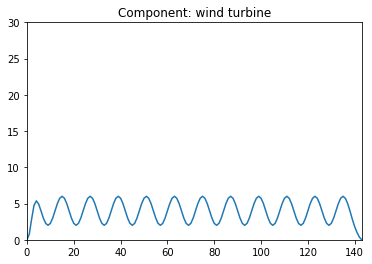

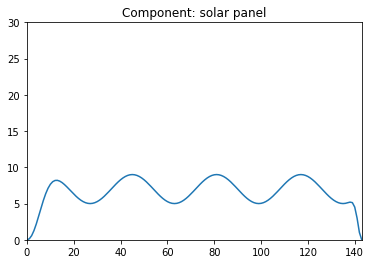

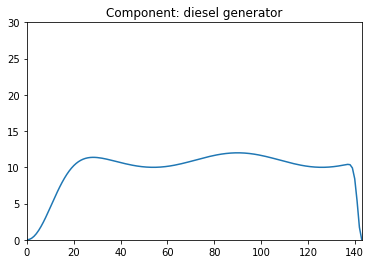

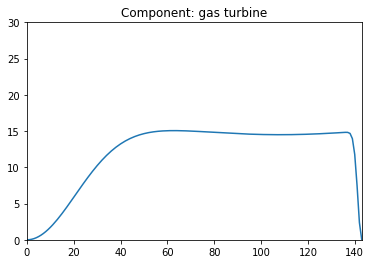

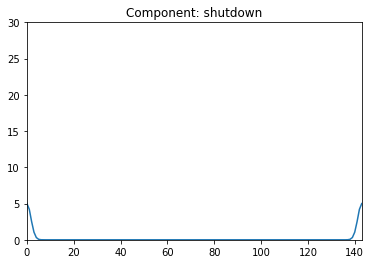

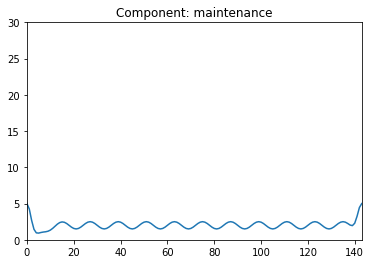

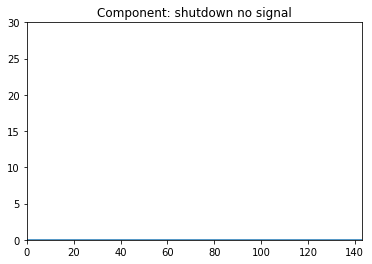

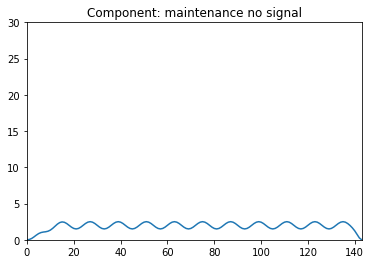

In [5]:
# plot components
t = np.arange(0, 12 * 12, 1)
WT = wind_turbine(t, 12)
plot_component(t, WT, 'wind turbine')
SP = solar_panel(t, 12)
plot_component(t, SP, 'solar panel')
DG = diesel_generator(t, 12)
plot_component(t, DG, 'diesel generator')
GT = gas_turbine(t, 12)
plot_component(t, GT, 'gas turbine')
s = np.array([5 for m in t])
Sh = shutdown(t, s, 12)
plot_component(t, Sh, 'shutdown')
Mt = maintenance(t, s, 12)
plot_component(t, Mt, 'maintenance')
s = np.array([0 for m in t])
Sh = shutdown(t, s, 12)
plot_component(t, Sh, 'shutdown no signal')
Mt = maintenance(t, s, 12)
plot_component(t, Mt, 'maintenance no signal')

# Creating the event log

**Events:**

- a = start wind turbine
- b = stop wind turbine
- c = start solar panel
- d = stop solar panel
- e = start diesel generator
- f = stop diesel generator
- g = start gas turbine
- h = stop gas turbine
- i = start grid maintenance
- j = stop grid maintenance
- k = start shutdown
- l = stop shutdown

**Event probabilities (how many times per 365 days):**

- a (wind): 30 %
- c (solar): 25 %
- e (diesel): 20 %
- g (gas): 17 %
- i (maintenance): 6 %
- k (shutdown): 2 %

**SIMPLE control strategy:**

This strategy can be made much more complex (e.g. dependent on power demand etc...)

1. Randomly start and event on a given timestamp.
2. Stop the event after x hours and $x \in {1, 2, 6, 12, 24}$.
3. Superposition all the events.

Rules:

- event can only start after it stopped

In [5]:
def simple_event_log_generator(time_interval=datetime.timedelta(seconds=300), total_time=365, no_event_prob = 0.9, mph=None):
    """ 
    param time_interval: time interval between every 'measurement'
    param total_time: total length of the simulation in days
    param mph: measurements per hour
    
    returns: event log (pandas dataframe)
    """
    
    # instantiate empty dataframe
    begin_date = datetime.datetime(2018, 1, 1, 0, 0)
    index = [begin_date + i * time_interval for i in range(int(datetime.timedelta(days=total_time) / time_interval))]
    event_log = pd.DataFrame(0, index=index, columns=['a', 'c', 'e', 'g', 'i', 'k'])
    event_log['events'] = ''
    if mph is None:
        mph = int(datetime.timedelta(hours=1) / time_interval)
    assert mph > 1, 'ERROR - less than 1 measurement per hour (can be changed)'
    
    # possible actions and action list
    events = {
        'a': 'start wind turbine',
        'b': 'stop wind turbine',
        'c': 'start solar panel',
        'd': 'stop solar panel',
        'e': 'start diesel generator',
        'f': 'stop diesel generator',
        'g': 'start gas turbine',
        'h': 'stop gas turbine',
        'i': 'start grid maintenance',
        'j': 'stop grid maintenance',
        'k': 'start shutdown',
        'l': 'stop shutdown',
        'z': 'no event',
    }
    
    # 80 % of the time no event happens
    event_probabilities = {
        'z': no_event_prob,
        'a': (1.0 - no_event_prob) * 0.35,
        'c': (1.0 - no_event_prob) * 0.265,
        'e': (1.0 - no_event_prob) * 0.22,
        'g': (1.0 - no_event_prob) * 0.15,
        'i': (1.0 - no_event_prob) * 0.01,
        'k': (1.0 - no_event_prob) * 0.005,
    }
    
    # complementary events
    complementary_event = {
        'a': 'b',
        'b': 'a',
        'c': 'd',
        'd': 'e',
        'e': 'f',
        'f': 'e',
        'g': 'h',
        'h': 'g',
        'i': 'j',
        'j': 'i',
        'k': 'l',
        'l': 'k',
    }
    
    # event sets
    base_events = ['a', 'c', 'e', 'g']
    start_events = ['a', 'c', 'e', 'g', 'i', 'k', 'z']
    stop_events = ['b', 'd', 'f', 'h', 'j', 'l', 'z']
    
    # possible time intervals between actions (in hours)
    runtimes = [4 * mph, 6 * mph, 12 * mph, 24 * mph]
    
    # starting action list + running_events
    selection_probs = np.array([event_probabilities[s] for s in start_events])
    running_actions = {a: 0 for a in start_events}
    running_list = []
    
    # generate the event log
    """ ONLY START AFTER 1 HOUR? """
    for i in tqdm(range(len(index))):
        current_time = index[i]
        
        # 1. select an action with probability
        e = np.random.choice(start_events, 1, p=selection_probs)[0]
        rt = np.random.choice(runtimes, 1)[0]
        
        # 2. abort non-event, running, when maintenance or shutdown is running (also prevents maitenance and shutdown from cooccuring)
        if e == 'z' or running_actions[e] > 0 or running_actions['i'] > 0 or running_actions['k'] > 0:
            skip = True
        else:
            skip = False
            
        # 3. log the action
        if not(skip):
            running_actions[e] = rt + 1
            
        # 4. if maintenance or shutdown --> clear all other actions
        if e in ['i', 'k']:
            for a in base_events:
                running_actions[a] = 0
            
        # 5. remove actions from running_actions
        running_list = []
        stopping_list = []
        all_running = []
        for a, rt in running_actions.items():
            nrt = max(0, rt - 1)
            running_actions[a] = nrt
            if nrt > 2:
                running_list.append(a)
            if nrt <= 2 and nrt > 0:
                stopping_list.append(complementary_event[a])
            if nrt > 0:
                all_running.append(a)
                
        all_actions = running_list + stopping_list
        
        # 5. log the running actions
        """ DO NOT FORGET THE STOP ACTIONS """
        event_log.at[current_time, 'events'] = '-'.join(all_actions)
        for al in all_running:
            event_log.at[current_time, al] = 1.0
                
    return event_log, mph, events

# Creating the continuous time series

In [6]:
def simple_cont_variable_generator(event_log, mph, base_events=['a', 'c', 'e', 'g'], base_level=2):
    """
    param event_log: event log data (pandas dataframe)
    
    returns: continuous_var (pandas dataframe)
    """
    
    # instantiate an empty dataframe
    continuous_var = pd.DataFrame(0.0, index=event_log.index.values, columns=base_events)
    
    # generate the behaviour for the base events: wind, solar, diesel, gas
    for i, event in enumerate(base_events):
        locs = event_log[event].values
        ranges = _find_pattern_ranges(locs)
        for r in ranges:
            t = np.arange(0, len(r), 1)
            response = _get_event_response(event, t, None, mph)
            continuous_var.iloc[r, i] = response
    
    # superimpose behaviours
    continuous_var['power'] = np.sum(continuous_var, axis=1) + base_level
    
    # generate the behaviour for: shutdown, maintenance (shutdown supercedes everything!)
    for i, event in enumerate(['i', 'k']):
        locs = event_log[event].values
        ranges = _find_pattern_ranges(locs)
        for r in ranges:
            t = np.arange(0, len(r), 1)
            signal = continuous_var.iloc[r, -1].values
            response = _get_event_response(event, t, signal, mph)
            continuous_var.iloc[r, -1] = response
            
    # combine them
    data = pd.DataFrame(index=event_log.index.values)
    data['var'] = continuous_var['power']
    data['events'] = event_log['events']
    data['label'] = -1.0
    
    return data, continuous_var

def _get_event_response(event, t, signal, mph):
    if event == 'a':
        return wind_turbine(t, mph)
    elif event == 'c':
        return solar_panel(t, mph)
    elif event == 'e':
        return diesel_generator(t, mph)
    elif event == 'g':
        return gas_turbine(t, mph)
    elif event == 'i':
        return maintenance(t, signal, mph)
    elif event == 'k':
        return shutdown(t, signal, mph)
    else:
        sys.exit('Unknown event response')
        
def _find_pattern_ranges(y):
    """ Find the indices of each event. """

    ranges = []
    ix = np.where(y == 1.0)[0]
    if len(ix) > 0:
        bp, ep = ix[0], ix[0]
        for i, e in enumerate(ix):
            if i == len(ix) - 1:
                if e - ep > 1:
                    ranges.append(np.arange(bp, ep+1, 1))
                else:
                    ranges.append(np.arange(bp, e+1, 1))
            elif e - ep > 1:
                ranges.append(np.arange(bp, ep+1, 1))
                bp = e
            ep = e
    return np.array(ranges)

# Adding the anomalies

Different types of anomalies:

- Type 1: anomalies in the event log (i.e., actions that are not registered in the continous variable)
- Type 2: anomalies in the continuous data that are independent of the event log (i.e., effects that do not correspond to an action)
- Type 3: anomalies in both the event log and the continuous data (i.e., actions that do have a different effect than anticipated)

In [7]:
def add_anomalies(data, mph, n_type1=20, n_type2=20, n_type3=20):
    """ Introduce the anomalies """
    
    new_data = copy.deepcopy(data)
    n, _ = new_data.shape
    times = new_data.index.values
    
    new_data['lt1'] = -1.0
    new_data['lt2'] = -1.0
    new_data['lt3'] = -1.0
    
    anom_times = [1 * mph, 2 * mph]
    
    # select all the ranges for the anomalies
    stop = False
    n_all = n_type1 + n_type2 + n_type3
    while not stop:
        start_points = np.random.choice(np.arange(0, n - (max(anom_times) + 1), mph), n_all, replace=False)
        ranges = []
        for i, sp in enumerate(start_points):
            l = np.random.choice(anom_times, 1)[0]
            r = np.arange(sp, sp+l, 1)
            good = True
            for j, sp2 in enumerate(start_points):
                if i != j and sp2 in r:
                    good = False
            if good:
                ranges.append(times[r])
        if len(ranges) == n_all:
            stop = True
            
    for r in ranges:
        if len(r) < mph:
            sys.exit('ERROR - anomaly duration not long enough')
    
    random.shuffle(ranges)
    t1_r = ranges[:n_type1]
    t2_r = ranges[n_type1:n_type1+n_type2]
    t3_r = ranges[n_type1+n_type2:n_type1+n_type2+n_type3]
    assert len(t1_r) == n_type1, 'ERROR - not enough anomalies of type 1'
    assert len(t2_r) == n_type2, 'ERROR - not enough anomalies of type 2'
    assert len(t3_r) == n_type3, 'ERROR - not enough anomalies of type 3'
    
    possible_actions = set(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l'])
    
    # 1. add n_type1 anomalies (actions without effects)
    for r in t1_r:
        elog = new_data.loc[r, 'events'].values
        
        """ ANOMALY = UNIQUE ACTION """
        uas = set(np.unique(['-'.join(elog).split('-')]))
        anom_actions = list(possible_actions - uas)
        #print(uas, anom_actions)
        
        if len(anom_actions) > 0:
            r_action = np.random.choice(anom_actions, 1)[0]
            for i, e in enumerate(elog):
                elog[i] = e + '-' + r_action
            new_data.loc[r, 'events'] = elog
            # add the labels
            new_data.loc[r, 'lt1'] = 1.0
    print('finished type 1')
        
    # 2. add n_type2 anomalies (effects without actions)
    for r in t2_r:
        r_action = np.random.choice(['a', 'c', 'e', 'g', 'i', 'k'], 1)[0]
        signal = new_data.loc[r, 'var'].values
        t = np.arange(0, len(r), 1)
        r_response = _get_event_response(r_action, t, signal, mph)
        
        """ REPLACE THE CURRENT SIGNAL WITH RESPONSE OR ADD """
        new_data.loc[r, 'var'] = r_response
        
        # add the labels
        new_data.loc[r, 'lt2'] = 1.0
    print('finished type 2')
        
    # 3. add n_type3 anomalies (actions with unforseen effect)
    for r in t3_r:
        # add to event log
        elog = new_data.loc[r, 'events'].values
        
        """ ANOMALY = UNIQUE ACTION """
        uas = set(np.unique(['-'.join(elog).split('-')]))
        ra_act = np.random.choice(list(set(['b', 'd', 'f', 'h', 'j', 'l']) - uas), 1)[0]
        ra_eff = np.random.choice(list(set(['a', 'c', 'e', 'g', 'i', 'k']) - uas), 1)[0]
        #print(uas, anom_actions)
        
        
        for i, e in enumerate(elog):
            elog[i] = e + '-' + ra_act
        new_data.loc[r, 'events'] = elog
        # add to continuous
        signal = new_data.loc[r, 'var'].values
        t = np.arange(0, len(r), 1)
        r_response = _get_event_response(ra_eff, t, signal, mph)
        
        """ REPLACE THE CURRENT SIGNAL WITH RESPONSE OR ADD """
        #new_data.loc[r, 'var'] += r_response
        new_data.loc[r, 'var'] = r_response
        
        # add the labels
        new_data.loc[r, 'lt3'] = 1.0
    print('finished type 3')
        
    # Add the labels
    for r in ranges:
        new_data.loc[r, 'label'] = 1.0
        
    return new_data

# Run PBAD on the generated synthetic data

In [8]:
sys.path.insert(0, '/home/vincentv/dtaijupiter/projects/camera_ready_PBAD/src/')
from methods.PBAD import PBAD
from methods.PreProcessor import PreProcessor
from sklearn.metrics import roc_auc_score, average_precision_score

In [11]:
def _run_PBAD(input_data, use='continuous'):
    # get the data
    data = copy.deepcopy(input_data[:12*24*500])
    cont_series = {0: data['var'].values}
    event_log = {0: data['events'].values}
    labels = data['label'].values
    
    # preprocess
    prep = PreProcessor(
        remove_extremes=True,
        minmax_scaling=False,
        add_scaling=False,                                  # data_settings['scaling']
        smoothing=False,
        label_scheme=2,
        discretize=True,
        alphabet_size=15,
        window_size=12,
        window_incr=12,
        bin_size=1,
    )
    cd_D, cd_UD, ed_D, window_labels = prep.preprocess(cont_series, event_log, labels=labels, return_undiscretized=True)
    ixl = np.where(window_labels != 0)[0]
    
    # run PBAD on the data
    detector = PBAD(
        pattern_type='all',
        relative_minsup=0.01,
        jaccard_threshold=0.9,
        pattern_pruning='closed',
        distance_formula=1,
        exact_match=False,
        sequential_minlength=2,
    )
    if use == 'continuous':
        scores = detector.fit_predict(cd_UD, cd_D)
    elif use == 'logs':
        scores = detector.fit_predict(event_data=ed_D)
    else:
        scores = detector.fit_predict(cd_UD, cd_D, ed_D)
    
    # compute the result
    auc = roc_auc_score(y_true=window_labels[ixl], y_score=scores[ixl])
    ap = average_precision_score(y_true=window_labels[ixl], y_score=scores[ixl])
    
    return auc, ap

## Run PBAD on different variations with different types of anomalies inserted

In [10]:
event_dict = {
        'a': 'start wind turbine',
        'b': 'stop wind turbine',
        'c': 'start solar panel',
        'd': 'stop solar panel',
        'e': 'start diesel generator',
        'f': 'stop diesel generator',
        'g': 'start gas turbine',
        'h': 'stop gas turbine',
        'i': 'start grid maintenance',
        'j': 'stop grid maintenance',
        'k': 'start shutdown',
        'l': 'stop shutdown',
        'z': 'no event',}

# event logs (100 days for checking)
event_log, mph, events = simple_event_log_generator(total_time=365 * 1, no_event_prob=0.85)

# Permutations
from itertools import permutations
ntypes = [np.array(list(l)) * 10 for l in list(permutations(range(10),3)) if sum(l) == 9] + [np.array([0, 0, 90]), np.array([0, 90, 0]), np.array([90, 0, 0])]

# Results
df_res = pd.DataFrame(0.0, columns=['ntype_1', 'ntype_2', 'ntype_3', 'cont_AUC', 'event_AUC', 'combo_AUC', 'cont_AP', 'event_AP', 'combo_AP'], index=range(len(ntypes)))

100%|██████████| 105120/105120 [00:12<00:00, 8107.49it/s]


In [12]:
# Run PBAD
for i, types in enumerate(ntypes):
    # continuous data
    data, cv = simple_cont_variable_generator(event_log.copy(), mph)
    final_data = add_anomalies(data, mph, n_type1=types[0], n_type2=types[1], n_type3=types[2])
    
    # run + store
    auc, ap = _run_PBAD(final_data, 'continuous')
    df_res.loc[i, 'cont_AUC'] = auc
    df_res.loc[i, 'cont_AP'] = ap
    
    auc, ap = _run_PBAD(final_data, 'logs')
    df_res.loc[i, 'event_AUC'] = auc
    df_res.loc[i, 'event_AP'] = ap
    
    auc, ap = _run_PBAD(final_data, 'both')
    df_res.loc[i, 'combo_AUC'] = auc
    df_res.loc[i, 'combo_AP'] = ap

    # stores types
    df_res.loc[i, 'ntype_1'] = types[0]
    df_res.loc[i, 'ntype_2'] = types[1]
    df_res.loc[i, 'ntype_3'] = types[2]

finished type 1
finished type 2
finished type 3

Running preprocessor on TIME SERIES with settings & steps:
0. remove extreme values (mean +/- 3 * stdv)    YES
1. Min-Max scaling      NO
2. Additional scaling:  NO
3. Smoothing:           NO
4. Binning:             NO
5. Subsampling:         NO
6. Discretizing:        YES
   alphabet size:       15
7. Window (size - inc): 12 - 12
WARNING preprocess: the event log is expected to be an array of strings, in each string, events are separated by `-`
Event logs are preprocessed without: scaling, smoothing, discretizing. Only subsampling + binning + windowing are applied.

DEBUG: Mining CLOSED ITEMSETS with SPMF CHARM; #rows:8760 minsup relative: 0.01

DEBUG: Found #162 patterns
DEBUG: # Jaccard thresholded patterns: 138
DEBUG: most frequent patterns: [(array([ 0.]), 2679), (array([ 23.64]), 2354), (array([ 26.59]), 2187), (array([ 20.68]), 2096), (array([ 35.46]), 2072)]
DEBUG: least frequent patterns: [(array([ 23.64,  35.46,  38.41]), 92), 

PBAD - mining patterns + constructing features for continuous data took: 7.7250776290893555 seconds
(8760, 38)
(8760, 143)
PBAD - training classifier took: 2.863147735595703 seconds

Running preprocessor on TIME SERIES with settings & steps:
0. remove extreme values (mean +/- 3 * stdv)    YES
1. Min-Max scaling      NO
2. Additional scaling:  NO
3. Smoothing:           NO
4. Binning:             NO
5. Subsampling:         NO
6. Discretizing:        YES
   alphabet size:       15
7. Window (size - inc): 12 - 12
WARNING preprocess: the event log is expected to be an array of strings, in each string, events are separated by `-`
Event logs are preprocessed without: scaling, smoothing, discretizing. Only subsampling + binning + windowing are applied.

DEBUG: Mining CLOSED ITEMSETS with SPMF CHARM; #rows:8760 minsup relative: 0.01

DEBUG: Found #88 patterns
DEBUG: # Jaccard thresholded patterns: 44
DEBUG: most frequent patterns: [(array([ 0.]), 6061), (array([ 0.,  2.]), 5287), (array([ 0., 

PBAD - training classifier took: 2.2296254634857178 seconds

Running preprocessor on TIME SERIES with settings & steps:
0. remove extreme values (mean +/- 3 * stdv)    YES
1. Min-Max scaling      NO
2. Additional scaling:  NO
3. Smoothing:           NO
4. Binning:             NO
5. Subsampling:         NO
6. Discretizing:        YES
   alphabet size:       15
7. Window (size - inc): 12 - 12
WARNING preprocess: the event log is expected to be an array of strings, in each string, events are separated by `-`
Event logs are preprocessed without: scaling, smoothing, discretizing. Only subsampling + binning + windowing are applied.

DEBUG: Mining CLOSED ITEMSETS with SPMF CHARM; #rows:8760 minsup relative: 0.01

DEBUG: Found #164 patterns
DEBUG: # Jaccard thresholded patterns: 140
DEBUG: most frequent patterns: [(array([ 0.]), 2666), (array([ 23.64]), 2346), (array([ 26.59]), 2188), (array([ 20.68]), 2096), (array([ 35.46]), 2069)]
DEBUG: least frequent patterns: [(array([  8.86,  11.82,  20

PBAD - mining patterns + constructing features for continuous data took: 7.323993682861328 seconds

DEBUG: Mining CLOSED ITEMSETS with SPMF CHARM; #rows:8760 minsup relative: 0.01

DEBUG: Found #88 patterns
DEBUG: # Jaccard thresholded patterns: 44
DEBUG: most frequent patterns: [(array([ 0.]), 6061), (array([ 0.,  2.]), 5287), (array([ 0.,  4.]), 5154), (array([ 0.,  6.]), 4675), (array([ 0.,  2.,  4.]), 4517)]
DEBUG: least frequent patterns: [(array([ 0.,  8.]), 107), (array([ 11.]), 95), (array([ 2.,  8.]), 91), (array([ 4.,  8.]), 90), (array([ 6.,  8.]), 88)]

DEBUG: Mining CLOSED SEQUENTIAL PATTERNS with ClasP; #rows:8760 minsup relative: 0.01

DEBUG: Found #0 patterns
DEBUG: # Jaccard thresholded patterns: 0
DEBUG: most frequent patterns: []
DEBUG: least frequent patterns: []
PBAD - mining patterns + constructing features for event data took: 1.9417893886566162 seconds
(8760, 38)
(8760, 139)
(8760, 44)
PBAD - training classifier took: 2.735074758529663 seconds
finished type 1
fi

DEBUG: Found #165 patterns
DEBUG: # Jaccard thresholded patterns: 140
DEBUG: most frequent patterns: [(array([ 0.]), 2666), (array([ 23.64]), 2342), (array([ 26.59]), 2185), (array([ 20.68]), 2084), (array([ 35.46]), 2076)]
DEBUG: least frequent patterns: [(array([  8.86,  11.82,  20.68]), 90), (array([ 0.  ,  2.95,  5.91,  8.86]), 90), (array([ 32.5 ,  35.46,  38.41,  41.36]), 89), (array([  0.  ,  14.77]), 89), (array([ 14.77,  17.73,  20.68,  23.64,  26.59]), 88)]

DEBUG: Mining CLOSED SEQUENTIAL PATTERNS with ClasP; #rows:8760 minsup relative: 0.01

DEBUG: Found #165 patterns
DEBUG: # Jaccard thresholded patterns: 72
DEBUG: most frequent patterns: [(array([ 0.]), 2666), (array([ 23.64]), 2342), (array([ 26.59]), 2185), (array([ 20.68]), 2084), (array([ 35.46]), 2076)]
DEBUG: least frequent patterns: [(array([ 0.  ,  2.95,  5.91,  8.86]), 90), (array([  8.86,  11.82,  20.68]), 90), (array([  0.  ,  14.77]), 89), (array([ 32.5 ,  35.46,  38.41,  41.36]), 89), (array([ 14.77,  17.73, 


DEBUG: Mining CLOSED ITEMSETS with SPMF CHARM; #rows:8760 minsup relative: 0.01

DEBUG: Found #87 patterns
DEBUG: # Jaccard thresholded patterns: 43
DEBUG: most frequent patterns: [(array([ 0.]), 6061), (array([ 0.,  2.]), 5287), (array([ 0.,  4.]), 5154), (array([ 0.,  6.]), 4675), (array([ 0.,  2.,  4.]), 4517)]
DEBUG: least frequent patterns: [(array([ 0.,  8.]), 107), (array([ 8.,  9.]), 106), (array([ 2.,  8.]), 91), (array([ 4.,  8.]), 90), (array([ 6.,  8.]), 88)]

DEBUG: Mining CLOSED SEQUENTIAL PATTERNS with ClasP; #rows:8760 minsup relative: 0.01

DEBUG: Found #0 patterns
DEBUG: # Jaccard thresholded patterns: 0
DEBUG: most frequent patterns: []
DEBUG: least frequent patterns: []
PBAD - mining patterns + constructing features for event data took: 2.1804590225219727 seconds
(8760, 43)
PBAD - training classifier took: 2.2171261310577393 seconds

Running preprocessor on TIME SERIES with settings & steps:
0. remove extreme values (mean +/- 3 * stdv)    YES
1. Min-Max scaling    

DEBUG: Found #159 patterns
DEBUG: # Jaccard thresholded patterns: 140
DEBUG: most frequent patterns: [(array([ 0.]), 2652), (array([ 23.64]), 2347), (array([ 26.59]), 2194), (array([ 20.68]), 2079), (array([ 35.46]), 2060)]
DEBUG: least frequent patterns: [(array([  0.  ,  17.73]), 89), (array([ 23.64,  35.46,  38.41]), 89), (array([  8.86,  11.82,  20.68]), 89), (array([ 17.73,  26.59,  32.5 ]), 88), (array([ 14.77,  17.73,  20.68,  23.64,  26.59]), 88)]

DEBUG: Mining CLOSED SEQUENTIAL PATTERNS with ClasP; #rows:8760 minsup relative: 0.01

DEBUG: Found #159 patterns
DEBUG: # Jaccard thresholded patterns: 69
DEBUG: most frequent patterns: [(array([ 0.]), 2652), (array([ 23.64]), 2347), (array([ 26.59]), 2194), (array([ 20.68]), 2079), (array([ 35.46]), 2060)]
DEBUG: least frequent patterns: [(array([  8.86,  11.82,  20.68]), 89), (array([  0.  ,  17.73]), 89), (array([ 23.64,  35.46,  38.41]), 89), (array([ 14.77,  17.73,  20.68,  23.64,  26.59]), 88), (array([ 17.73,  26.59,  32.5 ])

DEBUG: Found #0 patterns
DEBUG: # Jaccard thresholded patterns: 0
DEBUG: most frequent patterns: []
DEBUG: least frequent patterns: []
PBAD - mining patterns + constructing features for event data took: 1.883979082107544 seconds
(8760, 38)
(8760, 144)
(8760, 44)
PBAD - training classifier took: 2.7800393104553223 seconds
finished type 1
finished type 2
finished type 3

Running preprocessor on TIME SERIES with settings & steps:
0. remove extreme values (mean +/- 3 * stdv)    YES
1. Min-Max scaling      NO
2. Additional scaling:  NO
3. Smoothing:           NO
4. Binning:             NO
5. Subsampling:         NO
6. Discretizing:        YES
   alphabet size:       15
7. Window (size - inc): 12 - 12
WARNING preprocess: the event log is expected to be an array of strings, in each string, events are separated by `-`
Event logs are preprocessed without: scaling, smoothing, discretizing. Only subsampling + binning + windowing are applied.

DEBUG: Mining CLOSED ITEMSETS with SPMF CHARM; #rows:8

DEBUG: Found #161 patterns
DEBUG: # Jaccard thresholded patterns: 74
DEBUG: most frequent patterns: [(array([ 0.]), 2665), (array([ 23.64]), 2347), (array([ 26.59]), 2189), (array([ 20.68]), 2092), (array([ 35.46]), 2067)]
DEBUG: least frequent patterns: [(array([  8.86,  11.82,  20.68]), 92), (array([ 23.64,  35.46,  38.41]), 92), (array([ 32.5 ,  35.46,  38.41,  41.36]), 89), (array([ 17.73,  26.59,  32.5 ]), 89), (array([ 0.  ,  2.95,  5.91,  8.86]), 88)]
PBAD - mining patterns + constructing features for continuous data took: 7.376296520233154 seconds
(8760, 38)
(8760, 140)
PBAD - training classifier took: 2.7167561054229736 seconds

Running preprocessor on TIME SERIES with settings & steps:
0. remove extreme values (mean +/- 3 * stdv)    YES
1. Min-Max scaling      NO
2. Additional scaling:  NO
3. Smoothing:           NO
4. Binning:             NO
5. Subsampling:         NO
6. Discretizing:        YES
   alphabet size:       15
7. Window (size - inc): 12 - 12
WARNING preprocess: t

DEBUG: Found #0 patterns
DEBUG: # Jaccard thresholded patterns: 0
DEBUG: most frequent patterns: []
DEBUG: least frequent patterns: []
PBAD - mining patterns + constructing features for event data took: 1.9945971965789795 seconds
(8760, 45)
PBAD - training classifier took: 2.2602975368499756 seconds

Running preprocessor on TIME SERIES with settings & steps:
0. remove extreme values (mean +/- 3 * stdv)    YES
1. Min-Max scaling      NO
2. Additional scaling:  NO
3. Smoothing:           NO
4. Binning:             NO
5. Subsampling:         NO
6. Discretizing:        YES
   alphabet size:       15
7. Window (size - inc): 12 - 12
WARNING preprocess: the event log is expected to be an array of strings, in each string, events are separated by `-`
Event logs are preprocessed without: scaling, smoothing, discretizing. Only subsampling + binning + windowing are applied.

DEBUG: Mining CLOSED ITEMSETS with SPMF CHARM; #rows:8760 minsup relative: 0.01

DEBUG: Found #160 patterns
DEBUG: # Jaccard

PBAD - mining patterns + constructing features for continuous data took: 7.217075824737549 seconds

DEBUG: Mining CLOSED ITEMSETS with SPMF CHARM; #rows:8760 minsup relative: 0.01

DEBUG: Found #88 patterns
DEBUG: # Jaccard thresholded patterns: 45
DEBUG: most frequent patterns: [(array([ 0.]), 6061), (array([ 0.,  2.]), 5287), (array([ 0.,  4.]), 5154), (array([ 0.,  6.]), 4675), (array([ 0.,  2.,  4.]), 4517)]
DEBUG: least frequent patterns: [(array([ 8.,  9.]), 106), (array([ 2.,  8.]), 95), (array([ 6.,  8.]), 94), (array([ 4.,  8.]), 93), (array([ 11.]), 88)]

DEBUG: Mining CLOSED SEQUENTIAL PATTERNS with ClasP; #rows:8760 minsup relative: 0.01

DEBUG: Found #0 patterns
DEBUG: # Jaccard thresholded patterns: 0
DEBUG: most frequent patterns: []
DEBUG: least frequent patterns: []
PBAD - mining patterns + constructing features for event data took: 1.9381368160247803 seconds
(8760, 37)
(8760, 139)
(8760, 45)
PBAD - training classifier took: 2.799082040786743 seconds
finished type 1
fi

DEBUG: Found #163 patterns
DEBUG: # Jaccard thresholded patterns: 142
DEBUG: most frequent patterns: [(array([ 0.]), 2645), (array([ 23.64]), 2352), (array([ 26.59]), 2205), (array([ 20.68]), 2099), (array([ 35.46]), 2076)]
DEBUG: least frequent patterns: [(array([  0.  ,  14.77]), 90), (array([ 14.77,  17.73,  20.68,  23.64,  26.59]), 89), (array([ 32.5 ,  35.46,  38.41,  41.36]), 89), (array([ 17.73,  20.68,  23.64,  26.59,  29.55]), 88), (array([ 11.82,  14.77,  17.73,  20.68,  23.64]), 88)]

DEBUG: Mining CLOSED SEQUENTIAL PATTERNS with ClasP; #rows:8760 minsup relative: 0.01

DEBUG: Found #163 patterns
DEBUG: # Jaccard thresholded patterns: 73
DEBUG: most frequent patterns: [(array([ 0.]), 2645), (array([ 23.64]), 2352), (array([ 26.59]), 2205), (array([ 20.68]), 2099), (array([ 35.46]), 2076)]
DEBUG: least frequent patterns: [(array([  0.  ,  14.77]), 90), (array([ 32.5 ,  35.46,  38.41,  41.36]), 89), (array([ 14.77,  17.73,  20.68,  23.64,  26.59]), 89), (array([ 11.82,  14.77,


DEBUG: Mining CLOSED ITEMSETS with SPMF CHARM; #rows:8760 minsup relative: 0.01

DEBUG: Found #88 patterns
DEBUG: # Jaccard thresholded patterns: 44
DEBUG: most frequent patterns: [(array([ 0.]), 6062), (array([ 0.,  2.]), 5287), (array([ 0.,  4.]), 5154), (array([ 0.,  6.]), 4675), (array([ 0.,  2.,  4.]), 4517)]
DEBUG: least frequent patterns: [(array([ 0.,  8.]), 107), (array([ 11.]), 99), (array([ 2.,  8.]), 92), (array([ 4.,  8.]), 91), (array([ 6.,  8.]), 89)]

DEBUG: Mining CLOSED SEQUENTIAL PATTERNS with ClasP; #rows:8760 minsup relative: 0.01

DEBUG: Found #0 patterns
DEBUG: # Jaccard thresholded patterns: 0
DEBUG: most frequent patterns: []
DEBUG: least frequent patterns: []
PBAD - mining patterns + constructing features for event data took: 1.975015640258789 seconds
(8760, 44)
PBAD - training classifier took: 2.241537094116211 seconds

Running preprocessor on TIME SERIES with settings & steps:
0. remove extreme values (mean +/- 3 * stdv)    YES
1. Min-Max scaling      NO
2.

DEBUG: Found #164 patterns
DEBUG: # Jaccard thresholded patterns: 142
DEBUG: most frequent patterns: [(array([ 0.]), 2632), (array([ 23.64]), 2356), (array([ 26.59]), 2193), (array([ 20.68]), 2102), (array([ 35.46]), 2076)]
DEBUG: least frequent patterns: [(array([ 23.64,  35.46,  38.41]), 90), (array([ 14.77,  17.73,  20.68,  23.64,  26.59]), 89), (array([ 17.73,  20.68,  23.64,  26.59,  29.55]), 88), (array([ 11.82,  14.77,  17.73,  20.68,  23.64]), 88), (array([ 0.  ,  2.95,  5.91,  8.86]), 88)]

DEBUG: Mining CLOSED SEQUENTIAL PATTERNS with ClasP; #rows:8760 minsup relative: 0.01

DEBUG: Found #164 patterns
DEBUG: # Jaccard thresholded patterns: 70
DEBUG: most frequent patterns: [(array([ 0.]), 2632), (array([ 23.64]), 2356), (array([ 26.59]), 2193), (array([ 20.68]), 2102), (array([ 35.46]), 2076)]
DEBUG: least frequent patterns: [(array([ 23.64,  35.46,  38.41]), 90), (array([ 14.77,  17.73,  20.68,  23.64,  26.59]), 89), (array([ 17.73,  20.68,  23.64,  26.59,  29.55]), 88), (ar

DEBUG: Found #0 patterns
DEBUG: # Jaccard thresholded patterns: 0
DEBUG: most frequent patterns: []
DEBUG: least frequent patterns: []
PBAD - mining patterns + constructing features for event data took: 1.9747686386108398 seconds
(8760, 36)
(8760, 140)
(8760, 42)
PBAD - training classifier took: 2.7352778911590576 seconds
finished type 1
finished type 2
finished type 3

Running preprocessor on TIME SERIES with settings & steps:
0. remove extreme values (mean +/- 3 * stdv)    YES
1. Min-Max scaling      NO
2. Additional scaling:  NO
3. Smoothing:           NO
4. Binning:             NO
5. Subsampling:         NO
6. Discretizing:        YES
   alphabet size:       15
7. Window (size - inc): 12 - 12
WARNING preprocess: the event log is expected to be an array of strings, in each string, events are separated by `-`
Event logs are preprocessed without: scaling, smoothing, discretizing. Only subsampling + binning + windowing are applied.

DEBUG: Mining CLOSED ITEMSETS with SPMF CHARM; #rows:

DEBUG: Found #164 patterns
DEBUG: # Jaccard thresholded patterns: 71
DEBUG: most frequent patterns: [(array([ 0.]), 2651), (array([ 23.64]), 2351), (array([ 26.59]), 2198), (array([ 20.68]), 2092), (array([ 35.46]), 2063)]
DEBUG: least frequent patterns: [(array([  2.95,  14.77]), 89), (array([ 14.77,  17.73,  20.68,  23.64,  26.59]), 89), (array([ 17.73,  26.59,  32.5 ]), 88), (array([ 11.82,  14.77,  17.73,  20.68,  23.64]), 88), (array([  0.  ,  17.73]), 88)]
PBAD - mining patterns + constructing features for continuous data took: 7.198616027832031 seconds
(8760, 36)
(8760, 140)
PBAD - training classifier took: 2.7371957302093506 seconds

Running preprocessor on TIME SERIES with settings & steps:
0. remove extreme values (mean +/- 3 * stdv)    YES
1. Min-Max scaling      NO
2. Additional scaling:  NO
3. Smoothing:           NO
4. Binning:             NO
5. Subsampling:         NO
6. Discretizing:        YES
   alphabet size:       15
7. Window (size - inc): 12 - 12
WARNING preproces

DEBUG: Found #0 patterns
DEBUG: # Jaccard thresholded patterns: 0
DEBUG: most frequent patterns: []
DEBUG: least frequent patterns: []
PBAD - mining patterns + constructing features for event data took: 1.8976726531982422 seconds
(8760, 44)
PBAD - training classifier took: 2.289111852645874 seconds

Running preprocessor on TIME SERIES with settings & steps:
0. remove extreme values (mean +/- 3 * stdv)    YES
1. Min-Max scaling      NO
2. Additional scaling:  NO
3. Smoothing:           NO
4. Binning:             NO
5. Subsampling:         NO
6. Discretizing:        YES
   alphabet size:       15
7. Window (size - inc): 12 - 12
WARNING preprocess: the event log is expected to be an array of strings, in each string, events are separated by `-`
Event logs are preprocessed without: scaling, smoothing, discretizing. Only subsampling + binning + windowing are applied.

DEBUG: Mining CLOSED ITEMSETS with SPMF CHARM; #rows:8760 minsup relative: 0.01

DEBUG: Found #165 patterns
DEBUG: # Jaccard 

DEBUG: Found #164 patterns
DEBUG: # Jaccard thresholded patterns: 75
DEBUG: most frequent patterns: [(array([ 0.]), 2637), (array([ 23.64]), 2350), (array([ 26.59]), 2200), (array([ 20.68]), 2102), (array([ 35.46]), 2073)]
DEBUG: least frequent patterns: [(array([ 23.64,  35.46,  38.41]), 90), (array([ 32.5 ,  35.46,  38.41,  41.36]), 89), (array([ 14.77,  17.73,  20.68,  23.64,  26.59]), 89), (array([ 11.82,  14.77,  17.73,  20.68,  23.64]), 88), (array([ 17.73,  26.59,  32.5 ]), 88)]
PBAD - mining patterns + constructing features for continuous data took: 7.963805198669434 seconds

DEBUG: Mining CLOSED ITEMSETS with SPMF CHARM; #rows:8760 minsup relative: 0.01

DEBUG: Found #88 patterns
DEBUG: # Jaccard thresholded patterns: 44
DEBUG: most frequent patterns: [(array([ 0.]), 6061), (array([ 0.,  2.]), 5287), (array([ 0.,  4.]), 5154), (array([ 0.,  6.]), 4675), (array([ 0.,  2.,  4.]), 4517)]
DEBUG: least frequent patterns: [(array([ 8.,  9.]), 106), (array([ 11.]), 104), (array([ 2.,


DEBUG: Mining CLOSED ITEMSETS with SPMF CHARM; #rows:8760 minsup relative: 0.01

DEBUG: Found #162 patterns
DEBUG: # Jaccard thresholded patterns: 138
DEBUG: most frequent patterns: [(array([ 0.]), 2631), (array([ 23.64]), 2344), (array([ 26.59]), 2197), (array([ 20.68]), 2097), (array([ 35.46]), 2075)]
DEBUG: least frequent patterns: [(array([  8.86,  11.82,  20.68]), 90), (array([ 14.77,  17.73,  20.68,  23.64,  26.59]), 89), (array([ 32.5 ,  35.46,  38.41,  41.36]), 89), (array([ 11.82,  14.77,  17.73,  20.68,  23.64]), 88), (array([ 0.  ,  2.95,  5.91,  8.86]), 88)]

DEBUG: Mining CLOSED SEQUENTIAL PATTERNS with ClasP; #rows:8760 minsup relative: 0.01

DEBUG: Found #162 patterns
DEBUG: # Jaccard thresholded patterns: 69
DEBUG: most frequent patterns: [(array([ 0.]), 2631), (array([ 23.64]), 2344), (array([ 26.59]), 2197), (array([ 20.68]), 2097), (array([ 35.46]), 2075)]
DEBUG: least frequent patterns: [(array([  8.86,  11.82,  20.68]), 90), (array([ 32.5 ,  35.46,  38.41,  41.36]


DEBUG: Mining CLOSED ITEMSETS with SPMF CHARM; #rows:8760 minsup relative: 0.01

DEBUG: Found #87 patterns
DEBUG: # Jaccard thresholded patterns: 43
DEBUG: most frequent patterns: [(array([ 0.]), 6061), (array([ 0.,  2.]), 5288), (array([ 0.,  4.]), 5156), (array([ 0.,  6.]), 4675), (array([ 0.,  2.,  4.]), 4520)]
DEBUG: least frequent patterns: [(array([ 0.,  8.]), 111), (array([ 8.,  9.]), 108), (array([ 2.,  8.]), 96), (array([ 4.,  8.]), 94), (array([ 6.,  8.]), 91)]

DEBUG: Mining CLOSED SEQUENTIAL PATTERNS with ClasP; #rows:8760 minsup relative: 0.01

DEBUG: Found #0 patterns
DEBUG: # Jaccard thresholded patterns: 0
DEBUG: most frequent patterns: []
DEBUG: least frequent patterns: []
PBAD - mining patterns + constructing features for event data took: 1.9399175643920898 seconds
(8760, 43)
PBAD - training classifier took: 2.407860040664673 seconds

Running preprocessor on TIME SERIES with settings & steps:
0. remove extreme values (mean +/- 3 * stdv)    YES
1. Min-Max scaling     

DEBUG: Found #157 patterns
DEBUG: # Jaccard thresholded patterns: 136
DEBUG: most frequent patterns: [(array([ 0.]), 2630), (array([ 23.64]), 2342), (array([ 26.59]), 2190), (array([ 20.68]), 2095), (array([ 35.46]), 2066)]
DEBUG: least frequent patterns: [(array([ 32.5 ,  35.46,  38.41,  41.36]), 90), (array([  8.86,  11.82,  20.68]), 90), (array([ 17.73,  26.59,  32.5 ]), 89), (array([ 17.73,  20.68,  23.64,  26.59,  29.55]), 88), (array([ 14.77,  17.73,  20.68,  23.64,  26.59]), 88)]

DEBUG: Mining CLOSED SEQUENTIAL PATTERNS with ClasP; #rows:8760 minsup relative: 0.01

DEBUG: Found #157 patterns
DEBUG: # Jaccard thresholded patterns: 67
DEBUG: most frequent patterns: [(array([ 0.]), 2630), (array([ 23.64]), 2342), (array([ 26.59]), 2190), (array([ 20.68]), 2095), (array([ 35.46]), 2066)]
DEBUG: least frequent patterns: [(array([  8.86,  11.82,  20.68]), 90), (array([ 32.5 ,  35.46,  38.41,  41.36]), 90), (array([ 17.73,  26.59,  32.5 ]), 89), (array([ 14.77,  17.73,  20.68,  23.64,

DEBUG: Found #0 patterns
DEBUG: # Jaccard thresholded patterns: 0
DEBUG: most frequent patterns: []
DEBUG: least frequent patterns: []
PBAD - mining patterns + constructing features for event data took: 2.2275230884552 seconds
(8760, 36)
(8760, 141)
(8760, 42)
PBAD - training classifier took: 3.0765156745910645 seconds
finished type 1
finished type 2
finished type 3

Running preprocessor on TIME SERIES with settings & steps:
0. remove extreme values (mean +/- 3 * stdv)    YES
1. Min-Max scaling      NO
2. Additional scaling:  NO
3. Smoothing:           NO
4. Binning:             NO
5. Subsampling:         NO
6. Discretizing:        YES
   alphabet size:       15
7. Window (size - inc): 12 - 12
WARNING preprocess: the event log is expected to be an array of strings, in each string, events are separated by `-`
Event logs are preprocessed without: scaling, smoothing, discretizing. Only subsampling + binning + windowing are applied.

DEBUG: Mining CLOSED ITEMSETS with SPMF CHARM; #rows:876

DEBUG: Found #161 patterns
DEBUG: # Jaccard thresholded patterns: 69
DEBUG: most frequent patterns: [(array([ 0.]), 2626), (array([ 23.64]), 2352), (array([ 26.59]), 2192), (array([ 20.68]), 2091), (array([ 35.46]), 2078)]
DEBUG: least frequent patterns: [(array([ 0.  ,  5.91,  8.86]), 89), (array([ 14.77,  17.73,  20.68,  23.64,  26.59]), 89), (array([  0.  ,  17.73]), 88), (array([ 17.73,  20.68,  23.64,  26.59,  29.55]), 88), (array([ 11.82,  14.77,  17.73,  20.68,  23.64]), 88)]
PBAD - mining patterns + constructing features for continuous data took: 7.382960081100464 seconds
(8760, 36)
(8760, 139)
PBAD - training classifier took: 2.8595261573791504 seconds

Running preprocessor on TIME SERIES with settings & steps:
0. remove extreme values (mean +/- 3 * stdv)    YES
1. Min-Max scaling      NO
2. Additional scaling:  NO
3. Smoothing:           NO
4. Binning:             NO
5. Subsampling:         NO
6. Discretizing:        YES
   alphabet size:       15
7. Window (size - inc): 12 -

DEBUG: Found #0 patterns
DEBUG: # Jaccard thresholded patterns: 0
DEBUG: most frequent patterns: []
DEBUG: least frequent patterns: []
PBAD - mining patterns + constructing features for event data took: 2.0968403816223145 seconds
(8760, 45)
PBAD - training classifier took: 2.3747544288635254 seconds

Running preprocessor on TIME SERIES with settings & steps:
0. remove extreme values (mean +/- 3 * stdv)    YES
1. Min-Max scaling      NO
2. Additional scaling:  NO
3. Smoothing:           NO
4. Binning:             NO
5. Subsampling:         NO
6. Discretizing:        YES
   alphabet size:       15
7. Window (size - inc): 12 - 12
WARNING preprocess: the event log is expected to be an array of strings, in each string, events are separated by `-`
Event logs are preprocessed without: scaling, smoothing, discretizing. Only subsampling + binning + windowing are applied.

DEBUG: Mining CLOSED ITEMSETS with SPMF CHARM; #rows:8760 minsup relative: 0.01

DEBUG: Found #158 patterns
DEBUG: # Jaccard

DEBUG: Found #165 patterns
DEBUG: # Jaccard thresholded patterns: 72
DEBUG: most frequent patterns: [(array([ 0.]), 2621), (array([ 23.64]), 2362), (array([ 26.59]), 2210), (array([ 20.68]), 2106), (array([ 35.46]), 2075)]
DEBUG: least frequent patterns: [(array([  8.86,  11.82,  20.68]), 90), (array([ 14.77,  17.73,  20.68,  23.64,  26.59]), 89), (array([ 32.5 ,  35.46,  38.41,  41.36]), 89), (array([ 17.73,  20.68,  23.64,  26.59,  29.55]), 88), (array([ 11.82,  14.77,  17.73,  20.68,  23.64]), 88)]
PBAD - mining patterns + constructing features for continuous data took: 7.522843837738037 seconds

DEBUG: Mining CLOSED ITEMSETS with SPMF CHARM; #rows:8760 minsup relative: 0.01

DEBUG: Found #88 patterns
DEBUG: # Jaccard thresholded patterns: 44
DEBUG: most frequent patterns: [(array([ 0.]), 6062), (array([ 0.,  2.]), 5287), (array([ 0.,  4.]), 5155), (array([ 0.,  6.]), 4677), (array([ 0.,  2.,  4.]), 4518)]
DEBUG: least frequent patterns: [(array([ 8.,  9.]), 107), (array([ 11.]), 10

Event logs are preprocessed without: scaling, smoothing, discretizing. Only subsampling + binning + windowing are applied.

DEBUG: Mining CLOSED ITEMSETS with SPMF CHARM; #rows:8760 minsup relative: 0.01

DEBUG: Found #160 patterns
DEBUG: # Jaccard thresholded patterns: 138
DEBUG: most frequent patterns: [(array([ 0.]), 2617), (array([ 23.64]), 2357), (array([ 26.59]), 2202), (array([ 20.68]), 2095), (array([ 35.46]), 2069)]
DEBUG: least frequent patterns: [(array([  0.  ,  17.73]), 88), (array([ 17.73,  20.68,  23.64,  26.59,  29.55]), 88), (array([ 14.77,  17.73,  20.68,  23.64,  26.59]), 88), (array([ 17.73,  26.59,  32.5 ]), 88), (array([ 11.82,  14.77,  17.73,  20.68,  23.64]), 88)]

DEBUG: Mining CLOSED SEQUENTIAL PATTERNS with ClasP; #rows:8760 minsup relative: 0.01

DEBUG: Found #160 patterns
DEBUG: # Jaccard thresholded patterns: 70
DEBUG: most frequent patterns: [(array([ 0.]), 2617), (array([ 23.64]), 2357), (array([ 26.59]), 2202), (array([ 20.68]), 2095), (array([ 35.46]),


DEBUG: Mining CLOSED ITEMSETS with SPMF CHARM; #rows:8760 minsup relative: 0.01

DEBUG: Found #87 patterns
DEBUG: # Jaccard thresholded patterns: 43
DEBUG: most frequent patterns: [(array([ 0.]), 6064), (array([ 0.,  2.]), 5288), (array([ 0.,  4.]), 5155), (array([ 0.,  6.]), 4677), (array([ 0.,  2.,  4.]), 4518)]
DEBUG: least frequent patterns: [(array([ 0.,  8.]), 118), (array([ 8.,  9.]), 106), (array([ 2.,  8.]), 105), (array([ 4.,  8.]), 102), (array([ 6.,  8.]), 101)]

DEBUG: Mining CLOSED SEQUENTIAL PATTERNS with ClasP; #rows:8760 minsup relative: 0.01

DEBUG: Found #0 patterns
DEBUG: # Jaccard thresholded patterns: 0
DEBUG: most frequent patterns: []
DEBUG: least frequent patterns: []
PBAD - mining patterns + constructing features for event data took: 2.024137496948242 seconds
(8760, 43)
PBAD - training classifier took: 2.4876010417938232 seconds

Running preprocessor on TIME SERIES with settings & steps:
0. remove extreme values (mean +/- 3 * stdv)    YES
1. Min-Max scaling  

DEBUG: Found #160 patterns
DEBUG: # Jaccard thresholded patterns: 139
DEBUG: most frequent patterns: [(array([ 0.]), 2608), (array([ 23.64]), 2365), (array([ 26.59]), 2203), (array([ 20.68]), 2104), (array([ 35.46]), 2081)]
DEBUG: least frequent patterns: [(array([  2.95,  14.77]), 91), (array([ 14.77,  17.73,  20.68,  23.64,  26.59]), 89), (array([ 32.5 ,  35.46,  38.41,  41.36]), 89), (array([ 17.73,  20.68,  23.64,  26.59,  29.55]), 88), (array([ 11.82,  14.77,  17.73,  20.68,  23.64]), 88)]

DEBUG: Mining CLOSED SEQUENTIAL PATTERNS with ClasP; #rows:8760 minsup relative: 0.01

DEBUG: Found #160 patterns
DEBUG: # Jaccard thresholded patterns: 70
DEBUG: most frequent patterns: [(array([ 0.]), 2608), (array([ 23.64]), 2365), (array([ 26.59]), 2203), (array([ 20.68]), 2104), (array([ 35.46]), 2081)]
DEBUG: least frequent patterns: [(array([  0.  ,  17.73]), 91), (array([ 14.77,  17.73,  20.68,  23.64,  26.59]), 89), (array([ 32.5 ,  35.46,  38.41,  41.36]), 89), (array([ 11.82,  14.77,

DEBUG: Found #0 patterns
DEBUG: # Jaccard thresholded patterns: 0
DEBUG: most frequent patterns: []
DEBUG: least frequent patterns: []
PBAD - mining patterns + constructing features for event data took: 2.2299342155456543 seconds
(8760, 36)
(8760, 137)
(8760, 41)
PBAD - training classifier took: 3.604107141494751 seconds
finished type 1
finished type 2
finished type 3

Running preprocessor on TIME SERIES with settings & steps:
0. remove extreme values (mean +/- 3 * stdv)    YES
1. Min-Max scaling      NO
2. Additional scaling:  NO
3. Smoothing:           NO
4. Binning:             NO
5. Subsampling:         NO
6. Discretizing:        YES
   alphabet size:       15
7. Window (size - inc): 12 - 12
WARNING preprocess: the event log is expected to be an array of strings, in each string, events are separated by `-`
Event logs are preprocessed without: scaling, smoothing, discretizing. Only subsampling + binning + windowing are applied.

DEBUG: Mining CLOSED ITEMSETS with SPMF CHARM; #rows:8

DEBUG: # Jaccard thresholded patterns: 66
DEBUG: most frequent patterns: [(array([ 0.]), 2609), (array([ 23.64]), 2354), (array([ 26.59]), 2196), (array([ 20.68]), 2094), (array([ 35.46]), 2074)]
DEBUG: least frequent patterns: [(array([  8.86,  11.82,  20.68]), 91), (array([ 11.82,  26.59]), 91), (array([ 17.73,  26.59,  32.5 ]), 89), (array([ 32.5 ,  35.46,  38.41,  41.36]), 89), (array([ 11.82,  14.77,  17.73,  20.68,  23.64]), 88)]
PBAD - mining patterns + constructing features for continuous data took: 7.543523788452148 seconds
(8760, 35)
(8760, 134)
PBAD - training classifier took: 3.0099003314971924 seconds

Running preprocessor on TIME SERIES with settings & steps:
0. remove extreme values (mean +/- 3 * stdv)    YES
1. Min-Max scaling      NO
2. Additional scaling:  NO
3. Smoothing:           NO
4. Binning:             NO
5. Subsampling:         NO
6. Discretizing:        YES
   alphabet size:       15
7. Window (size - inc): 12 - 12
WARNING preprocess: the event log is expecte

DEBUG: Found #0 patterns
DEBUG: # Jaccard thresholded patterns: 0
DEBUG: most frequent patterns: []
DEBUG: least frequent patterns: []
PBAD - mining patterns + constructing features for event data took: 2.115575075149536 seconds
(8760, 42)
PBAD - training classifier took: 2.435426712036133 seconds

Running preprocessor on TIME SERIES with settings & steps:
0. remove extreme values (mean +/- 3 * stdv)    YES
1. Min-Max scaling      NO
2. Additional scaling:  NO
3. Smoothing:           NO
4. Binning:             NO
5. Subsampling:         NO
6. Discretizing:        YES
   alphabet size:       15
7. Window (size - inc): 12 - 12
WARNING preprocess: the event log is expected to be an array of strings, in each string, events are separated by `-`
Event logs are preprocessed without: scaling, smoothing, discretizing. Only subsampling + binning + windowing are applied.

DEBUG: Mining CLOSED ITEMSETS with SPMF CHARM; #rows:8760 minsup relative: 0.01

DEBUG: Found #157 patterns
DEBUG: # Jaccard t

DEBUG: Found #159 patterns
DEBUG: # Jaccard thresholded patterns: 67
DEBUG: most frequent patterns: [(array([ 0.]), 2593), (array([ 23.64]), 2356), (array([ 26.59]), 2199), (array([ 20.68]), 2096), (array([ 35.46]), 2080)]
DEBUG: least frequent patterns: [(array([ 17.73,  26.59,  32.5 ]), 89), (array([ 14.77,  17.73,  20.68,  23.64,  26.59]), 89), (array([ 32.5 ,  35.46,  38.41,  41.36]), 89), (array([ 17.73,  20.68,  23.64,  26.59,  29.55]), 88), (array([ 11.82,  14.77,  17.73,  20.68,  23.64]), 88)]
PBAD - mining patterns + constructing features for continuous data took: 7.380112648010254 seconds

DEBUG: Mining CLOSED ITEMSETS with SPMF CHARM; #rows:8760 minsup relative: 0.01

DEBUG: Found #87 patterns
DEBUG: # Jaccard thresholded patterns: 42
DEBUG: most frequent patterns: [(array([ 0.]), 6065), (array([ 0.,  2.]), 5289), (array([ 0.,  4.]), 5154), (array([ 0.,  6.]), 4676), (array([ 0.,  2.,  4.]), 4519)]
DEBUG: least frequent patterns: [(array([ 0.,  8.]), 116), (array([ 8.,  9.])


DEBUG: Mining CLOSED ITEMSETS with SPMF CHARM; #rows:8760 minsup relative: 0.01

DEBUG: Found #157 patterns
DEBUG: # Jaccard thresholded patterns: 136
DEBUG: most frequent patterns: [(array([ 0.]), 2580), (array([ 23.64]), 2365), (array([ 26.59]), 2207), (array([ 20.68]), 2106), (array([ 35.46]), 2081)]
DEBUG: least frequent patterns: [(array([ 32.5 ,  35.46,  38.41,  41.36]), 90), (array([ 14.77,  17.73,  20.68,  23.64,  26.59]), 89), (array([ 11.82,  14.77,  17.73,  20.68,  23.64]), 88), (array([ 17.73,  20.68,  23.64,  26.59,  29.55]), 88), (array([ 17.73,  26.59,  32.5 ]), 88)]

DEBUG: Mining CLOSED SEQUENTIAL PATTERNS with ClasP; #rows:8760 minsup relative: 0.01

DEBUG: Found #157 patterns
DEBUG: # Jaccard thresholded patterns: 66
DEBUG: most frequent patterns: [(array([ 0.]), 2580), (array([ 23.64]), 2365), (array([ 26.59]), 2207), (array([ 20.68]), 2106), (array([ 35.46]), 2081)]
DEBUG: least frequent patterns: [(array([  8.86,  11.82,  20.68]), 90), (array([ 14.77,  17.73,  20


DEBUG: Mining CLOSED ITEMSETS with SPMF CHARM; #rows:8760 minsup relative: 0.01

DEBUG: Found #88 patterns
DEBUG: # Jaccard thresholded patterns: 46
DEBUG: most frequent patterns: [(array([ 0.]), 6061), (array([ 0.,  2.]), 5287), (array([ 0.,  4.]), 5154), (array([ 0.,  6.]), 4675), (array([ 0.,  2.,  4.]), 4517)]
DEBUG: least frequent patterns: [(array([ 0.,  8.]), 107), (array([ 11.]), 106), (array([ 2.,  8.]), 91), (array([ 4.,  8.]), 90), (array([ 6.,  8.]), 88)]

DEBUG: Mining CLOSED SEQUENTIAL PATTERNS with ClasP; #rows:8760 minsup relative: 0.01

DEBUG: Found #0 patterns
DEBUG: # Jaccard thresholded patterns: 0
DEBUG: most frequent patterns: []
DEBUG: least frequent patterns: []
PBAD - mining patterns + constructing features for event data took: 1.938568353652954 seconds
(8760, 46)
PBAD - training classifier took: 2.5141966342926025 seconds

Running preprocessor on TIME SERIES with settings & steps:
0. remove extreme values (mean +/- 3 * stdv)    YES
1. Min-Max scaling      NO


DEBUG: Found #161 patterns
DEBUG: # Jaccard thresholded patterns: 138
DEBUG: most frequent patterns: [(array([ 0.]), 2658), (array([ 23.64]), 2352), (array([ 26.59]), 2188), (array([ 20.68]), 2094), (array([ 35.46]), 2061)]
DEBUG: least frequent patterns: [(array([ 32.5 ,  35.46,  38.41,  41.36]), 89), (array([  8.86,  11.82,  20.68]), 89), (array([ 17.73,  26.59,  32.5 ]), 88), (array([ 17.73,  20.68,  23.64,  26.59,  29.55]), 88), (array([ 11.82,  14.77,  17.73,  20.68,  23.64]), 88)]

DEBUG: Mining CLOSED SEQUENTIAL PATTERNS with ClasP; #rows:8760 minsup relative: 0.01

DEBUG: Found #161 patterns
DEBUG: # Jaccard thresholded patterns: 68
DEBUG: most frequent patterns: [(array([ 0.]), 2658), (array([ 23.64]), 2352), (array([ 26.59]), 2188), (array([ 20.68]), 2094), (array([ 35.46]), 2061)]
DEBUG: least frequent patterns: [(array([ 32.5 ,  35.46,  38.41,  41.36]), 89), (array([  8.86,  11.82,  20.68]), 89), (array([ 17.73,  20.68,  23.64,  26.59,  29.55]), 88), (array([ 11.82,  14.77,

DEBUG: Found #0 patterns
DEBUG: # Jaccard thresholded patterns: 0
DEBUG: most frequent patterns: []
DEBUG: least frequent patterns: []
PBAD - mining patterns + constructing features for event data took: 1.9059500694274902 seconds
(8760, 35)
(8760, 135)
(8760, 47)
PBAD - training classifier took: 2.9248855113983154 seconds


### Only itemsets

In [49]:
df_itemset = df_res.copy()

In [51]:
df_itemset.mean()

ntype_1      30.000000
ntype_2      30.000000
ntype_3      30.000000
cont_AUC      0.738290
event_AUC     0.704496
combo_AUC     0.796268
cont_AP       0.062082
event_AP      0.039514
combo_AP      0.049097
dtype: float64

### Itemsets and sequential patterns

In [14]:
df_res.mean()

ntype_1      30.000000
ntype_2      30.000000
ntype_3      30.000000
cont_AUC      0.673749
event_AUC     0.697113
combo_AUC     0.762865
cont_AP       0.027502
event_AP      0.039665
combo_AP      0.040083
dtype: float64

# Plot the data

In [27]:
event_dict = {
        'a': 'start wind',
        'b': 'stop wind',
        'c': 'start solar',
        'd': 'stop solar',
        'e': 'start diesel',
        'f': 'stop diesel',
        'g': 'start gas',
        'h': 'stop gas',
        'i': 'begin maint.',
        'j': 'end maint.',
        'k': 'begin shutdown',
        'l': 'end shutdown',
    }

plot_event_dict = {
        'a': 'BW',
        'b': 'EW',
        'c': 'BS',
        'd': 'ES',
        'e': 'BD',
        'f': 'ED',
        'g': 'BG',
        'h': 'EG',
        'i': 'BM',
        'j': 'EM',
        'k': 'BU',
        'l': 'EU',
    }

complement = {
        'a': 'b',
        'b': 'a',
        'c': 'd',
        'd': 'c',
        'e': 'f',
        'f': 'e',
        'g': 'h',
        'h': 'g',
        'i': 'j',
        'j': 'i',
        'k': 'l',
        'l': 'k',
    }

# figure
def __make_plot_v2(y_score, letter_size, start_ix, stop_ix, event_dict, complement, clean_up=True, verbose=False):
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 8), gridspec_kw={'height_ratios':[1.5, 1.5, 1]})
    plt.rc('text', usetex=True)
    plt.rc('font', family='CM')

    # add the signal
    signal = final_data['var'].values[start_ix:stop_ix]
    times = final_data.index.values[start_ix:stop_ix]
    labels = final_data['label'].values[start_ix:stop_ix]
    axes[0].plot(times, signal)
    axes[0].fill_between(times, 0, 50, where=labels > 0.5, facecolor='red', alpha=0.3, label='anomalies')
    axes[0].set_ylabel('Power', fontsize=letter_size, rotation='horizontal', horizontalalignment='right')
    axes[0].legend(fontsize=letter_size, loc='upper center')

    # clean up
    for i in range(3):
        axes[i].set_xlim([times[0], times[-1]])
        if i == 0:
            axes[i].set_ylim([0.0, 50])
        else:
            axes[i].set_ylim([0.0, 100])
        if i < 2:
            axes[i].set_xticklabels([])
        axes[i].set_yticklabels([])
        axes[i].set_yticks([], [])
        
    # plot the score
    axes[2].plot(times, y_score[start_ix:stop_ix], color='#d62728')
    axes[2].fill_between(times, 0, 1.01, where=labels > 0.5, facecolor='red', alpha=0.3, label='anomalies')
    axes[2].set_ylim([0.0, 1.01])
    axes[2].set_xlabel('Time', fontsize=letter_size)
    axes[2].set_ylabel(r'\textsc{Pbad}', fontsize=letter_size, rotation='horizontal', horizontalalignment='right')
    axes[2].set_xticklabels([])

    # plot the events: requires setting the axes first!
    # only plot the initial actions
    counter = 1
    events = final_data['events'].values[start_ix:stop_ix]
    for i, e in enumerate(events):
        actions = np.unique(e.split('-'))
        if actions[0] == '':
            running_actions = set()
            if verbose: print(i, 'current:', [''])
            continue
        current_events = [event_dict[a] for a in actions]
        if verbose: print(i, 'current:', current_events)
    
        plot_actions = set()
        if i == 0:
            running_actions = set(actions)
        else:
            if 'i' in actions and 'i' not in running_actions:
                plot_actions = set('i')
                running_actions = set('i')
            elif 'k' in actions and 'k' not in running_actions:
                plot_actions = set('k')
                running_actions = set('k')
            else:
                for a in actions:
                    if a not in running_actions:
                        running_actions.add(a)
                        plot_actions.add(a)
                    if complement[a] in running_actions:
                        running_actions.remove(complement[a])
                        running_actions.add(a)
                        plot_actions.add(a)
                    continue
        
        # final plot actions
        plot_actions = [event_dict[a] for a in plot_actions]
        if verbose: print('\tplotting:', plot_actions)
        # plot_actions = [pa for pa in plot_actions if ('start' in pa or 'begin' in pa)]

        # plot these actions (only after second time step)
        if i > 0:
            for ii, event in enumerate(plot_actions):
                if i == 204:
                    event = 'BU'
                axes[1].text(times[i], 105 - 23 * counter, event, zorder=i+1, bbox=dict(facecolor='#dfdddd', alpha=1.0, boxstyle='circle'), fontsize=20, label=event)
                #axes[1].arrow(times[i], 98 - 10 * counter, 0, 100 - (98 - 10 * counter), head_width=0, head_length=0, zorder=i+1)
                counter += 1
                if counter == 5: counter = 1

    axes[1].set_ylabel('Events', fontsize=letter_size, rotation='horizontal', horizontalalignment='right')
    axes[1].fill_between(times, 0, 100, where=labels > 0.5, facecolor='red', alpha=0.3, label='anomalies')

    # details + store
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

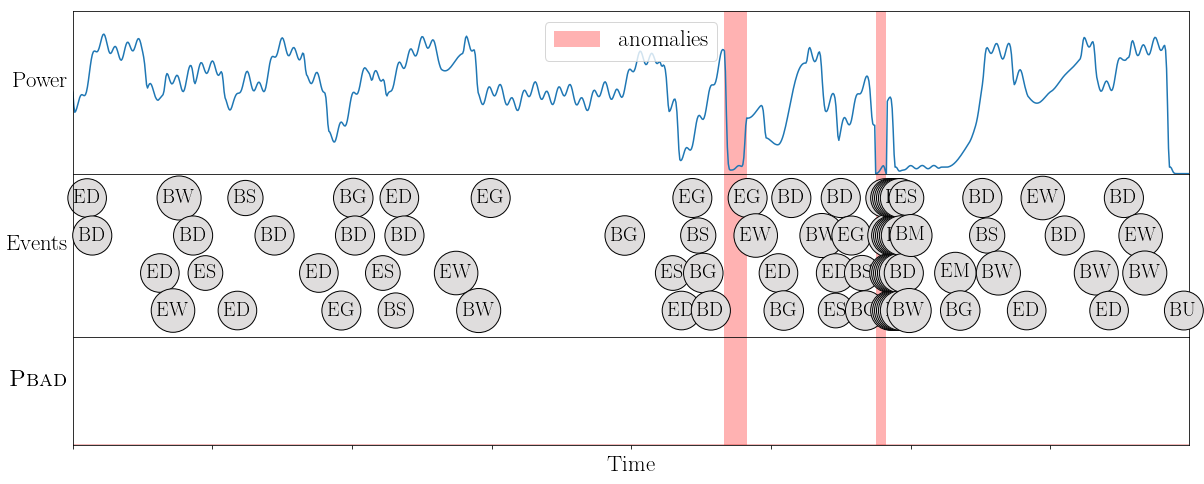

In [28]:
start_day = 101
end_day = 105

__make_plot_v2(np.zeros(len(final_data)), letter_size=23, start_ix=12 * 24 * start_day, stop_ix=12 * 24 * end_day, event_dict=plot_event_dict, complement=complement, clean_up=False, verbose=False)